In [9]:
import os
import numpy as np
from numpy import array
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import KaiserTracerPowerSpectrumMultipoles, TNSTracerPowerSpectrumMultipoles, FOLPSTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler

from desilike import setup_logging
setup_logging()  # for logging messages

In [10]:
kmin     = 0.008
kmax     = 0.2
binning  = 0.006
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

# the cosmology parameters
catalogue   = 'fiducial'  # fiducial, Mnu_p, Mnu_ppp -- QUIJOTE catalogue
cosmology   = 'LCDM'  # LCDM, nuCDM, nsFree, wCDM -- cosmology model
r_pk        = 'RSD'  # RSD, LRG, QSQ, CATAS-- systematics
CovRsf      = 25  # -- covariance rescale factor

systematic_map  = {
    'RSD': '',
    'LRG': '+LRGvsmear',
    'QSO': '+QSOvsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

In [11]:
redshift = 1.0
model = 'FOLPS' # Kaiser, TNS, FOLPS
r_pks = ['RSD','1%CATAS','5%CATAS']
systematic = systematic_map.get(r_pk, '')
emulator_fn = f'/Users/alain/Desktop/projectNU/main/RSD_tests/model/emulator_{model}_z{redshift}.npy'

for r_pk in r_pks:
    profile_fn = f'./profiler_result/profile_{model}_{r_pk}_z{redshift}.npy'
    if not os.path.exists(profile_fn):
        # data files
        filename = []
        filedir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/{r_pk}_z{redshift}/npy/'
        for file in os.listdir(filedir):
            filename.append(filedir+file)
        covariance = filedir+'*'
        theory = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        observable = TracerPowerSpectrumMultipolesObservable(data= filename,
                                                            covariance= covariance,
                                                            klim=klim,
                                                            theory=theory,
                                                            # kin=np.arange(0.001,0.35,0.002)
                                                            )
        likelihood = ObservablesGaussianLikelihood(observable, scale_covariance = 1/1) #
        likelihood()
        profiler = MinuitProfiler(likelihood, seed=42)
        profiles = profiler.maximize()
        profiles.save(profile_fn)
        print("Profiler finished")
        print(profiles.to_stats(tablefmt='pretty'))
        likelihood(**profiles.bestfit.choice(input=True))

In [7]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

[000079.94] [0/1] 06-10 09:56  Emulator                  INFO     Loading /Users/alain/Desktop/projectNU/main/RSD_tests/model/emulator_FOLPS_z0.5.npy.


[000080.62] [0/1] 06-10 09:56  Profiles                  INFO     Loading ./profiler_result/profile_FOLPS_RSD_z0.5.npy.
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
[000080.73] [0/1] 06-10 09:56  Emulator                  INFO     Loading /Users/alain/Desktop/projectNU/main/RSD_tests/model/emulator_FOLPS_z0.5.npy.
[000081.28] [0/1] 06-10 09:56  Profiles                  INFO     Loading ./profiler_result/profile_FOLPS_1%CATAS_z0.5.npy.
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/1%CATAS_z0.5/pk/fiducial_199_z0.5.pk
[000081.40] [0/1] 06-10 09:56  Emulator                  INFO     Loading /Users/alain/Desktop/projectNU/main/RSD_tests/model/emulator_FOLPS_z0.5.npy.
[000081.89] [0/1] 06-10 09:56  Profiles                  INFO     Loading ./profiler_result/profile_FOLPS_5%CATAS_z0.5.npy.
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/5%CATAS_z0.5/pk/fiducial_199_z0.5.pk
[000082.10] [0/1] 06-10 09:56  Emulator                

Text(0.81, 0.8, '$z=1.0 $')

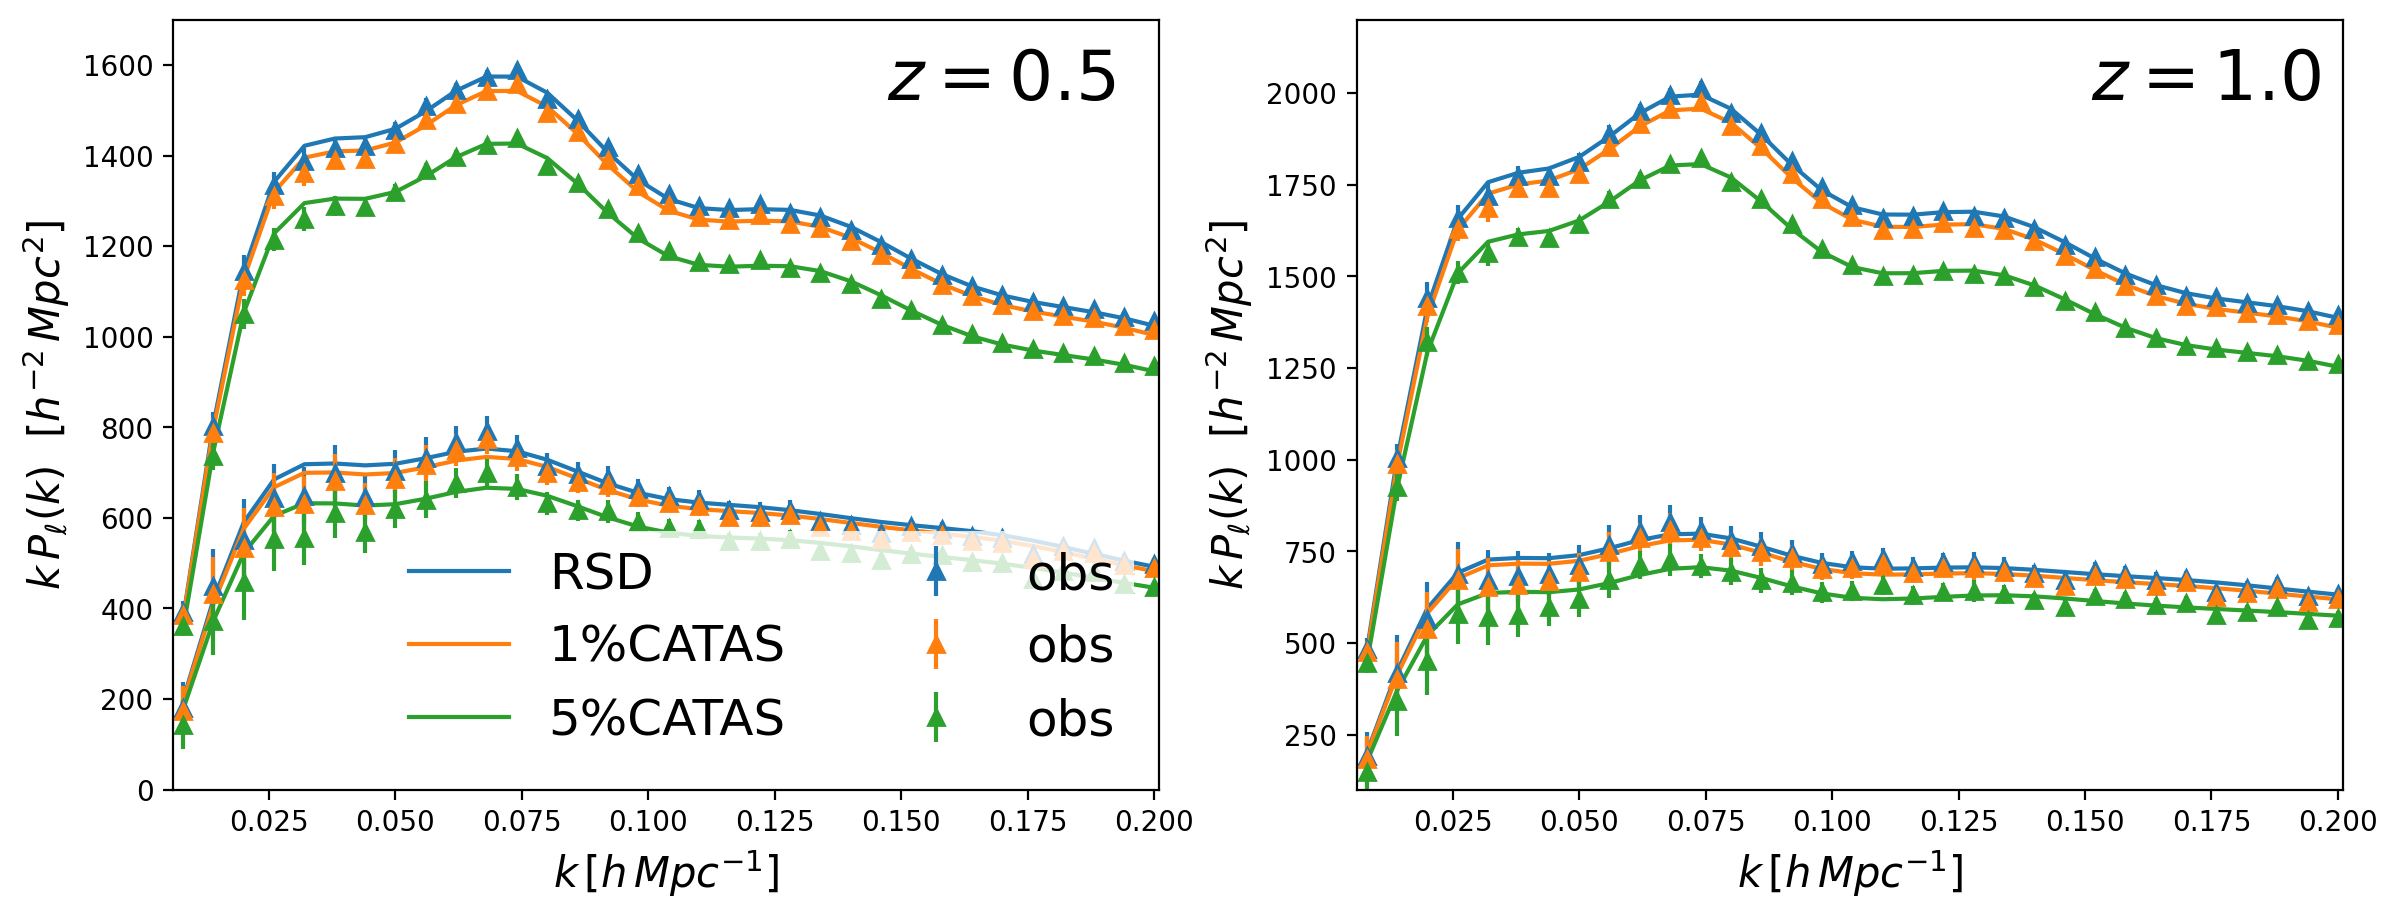

In [8]:
model = 'FOLPS'
r_pks = ['RSD','1%CATAS','5%CATAS']
colors = ['C0','C1','C2']

fig, axs = plt.subplots(1, 2, figsize = (14, 5),sharex=True)
for i,redshift in enumerate([0.5, 1.0]):
    Pkmodel = []
    Pkobs   = []
    for r_pk in r_pks:
        emulator_fn = f'/Users/alain/Desktop/projectNU/main/RSD_tests/model/emulator_{model}_z{redshift}.npy'
        profile_fn = f'./profiler_result/profile_{model}_{r_pk}_z{redshift}.npy'
        if model == 'Kaiser':
            theory = KaiserTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        elif model == 'TNS':
            theory = TNSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        elif model == 'FOLPS':
            theory = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        profile = Profiles.load(profile_fn)
        # print(profile.to_stats(tablefmt='pretty'))
        pkl = theory(**profile.bestfit.choice(input=True))
        Pkmodel.append(pkl)
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0,pk2])
    for ell, l in zip(['monopole','quadrupole'],range(2)):
        # axs[i].fill_between(k_ev, k_ev*(Pkobs[l][0]+Pkobs[l][1]), k_ev*(Pkobs[l][0]-Pkobs[l][1]), color='grey', alpha=0.5)
        for t in range(len(r_pks)):
            axs[i].plot(k_ev, k_ev*Pkmodel[t][l], color = colors[t], label = f"{r_pks[t]}")
            axs[i].errorbar(k_ev, k_ev*Pkobs[t][l][0], k_ev*Pkobs[t][l][1]/5, color=colors[t], alpha=1.0, fmt='^', label='obs')
        if i ==0 and l==0:
            leg2 = axs[0].legend(loc =4, fontsize =  18, ncol=2)
            leg2.get_frame().set_linewidth(0.0)
    axs[i].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  15)
    axs[i].set_ylabel(r'$k \, P_{\ell}(k)$  $[h^{-2} \, Mpc^{2}]$', fontsize =  15)
    plt.xlim([0.006, 0.201])
    if i == 0:
        axs[i].set_ylim([0, 1700])
    if i == 1:
        axs[i].set_ylim([100, 2200])

plt.figtext(0.38, 0.8, r'$z=0.5 $', fontsize=25)
plt.figtext(0.81, 0.8, r'$z=1.0 $', fontsize=25)